<a href="https://colab.research.google.com/github/kalinakalina/DEDA_Cryptopunks/blob/main/stepwise_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install, Imports and Helper Functions

In [131]:
!pip install linearmodels
!pip install prince
!pip install mca
!pip install mlxtend

In [132]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from linearmodels import PooledOLS
from linearmodels import PanelOLS
from linearmodels import RandomEffects

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

import numpy as np
from numpy import mean
from numpy import std
from numpy import absolute
from numpy import arange

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import meanabs

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import lightgbm as lgb
import xgboost as xgb
import prince
import mca

In [133]:
# Helper Function
def fix_df(x):
    x['punk_id'] = x['punk_id'].astype('category')
    x['type'] = x['type'].astype('category')
    x['from'] = x['from'].astype(str)
    x['to'] = x['to'].astype(str)
    x['date'] = pd.to_datetime(x['date'], format = '%Y.%m.%d')
    
    x['amount_in_eth'] = x['amount_in_eth'].astype(str)
    x['amount_in_eth'] = x['amount_in_eth'].str.replace('Y', '')
    x['amount_in_eth'] = x['amount_in_eth'].str.replace('Z', '')
    x['amount_in_eth'] = x['amount_in_eth'].str.replace('M', '')
    x['amount_in_eth'] = x['amount_in_eth'].str.replace('T', '')
    x['amount_in_eth'] = x['amount_in_eth'].str.replace('B', '')
    x['amount_in_eth'] = x['amount_in_eth'].replace(',', '', regex=True)
    x['amount_in_eth'] = x['amount_in_eth'].astype(float)

    x['amount_in_dol'] = x['amount_in_dol'].astype(str)
    x['amount_in_dol'] = x['amount_in_dol'].str.replace('Y', '')
    x['amount_in_dol'] = x['amount_in_dol'].str.replace('B', '')
    x['amount_in_dol'] = x['amount_in_dol'].str.replace('T', '')
    x['amount_in_dol'] = x['amount_in_dol'].str.replace('P', '')
    x['amount_in_dol'] = x['amount_in_dol'].str.replace('Z', '')
    x['amount_in_dol'] = x['amount_in_dol'].replace('<', '', regex=True)
    x['amount_in_dol'] = x['amount_in_dol'].replace(',', '', regex=True)
    x['amount_in_dol'] = x['amount_in_dol'].astype(float)
    
    x['amount_in_eth'] = x['amount_in_eth'].fillna(0)
    x['amount_in_dol'] = x['amount_in_dol'].fillna(0)

    return x

def outlier_truncation(x, factor=1.5):
    '''
    Identifies outlier values based on the inter-quartile range IQR. 
    Corresponding outliers are truncated and set to a contant value equal to the IQR
    times a factor, which, following Tuckey's rule, we set to 1.5 by default
    
        Parameters:
            x (Pandas Series): A data frame column to scan for outliers
            factor (float): An outlier is a value this many times the IQR above q3/below q1
            
        Returns:
            Adjusted variable in which outliers are truncated
    Source: https://github.com/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb
    '''
    x_new = x.copy()
    
    # Calculate IQR
    IQR = x.quantile(0.75) - x.quantile(0.25) 
    
    # Define upper/lower bound
    upper = x.quantile(0.75) + factor*IQR
    lower = x.quantile(0.25) - factor*IQR
    
    # Truncation
    x_new[x < lower] = lower
    x_new[x > upper] = upper
    
    return x_new

# Data Imports

In [134]:
# Read Transactions
file = 'https://raw.githubusercontent.com/kalinakalina/DEDA_Cryptopunks/main/data/transaction.csv'
df_tr = pd.read_csv(file, header = None, index_col = 0)
df_tr.columns = ['type', 'from', 'to', 'date', 'punk_id', 'amount_in_eth', 'amount_in_dol']
df_tr = df_tr[ ['punk_id'] + [ col for col in df_tr.columns if col != 'punk_id' ] ]
df_tr = fix_df(df_tr)
print('transaction head')
print(df_tr.head())
print()

# Read Accessoires
file2 = 'https://raw.githubusercontent.com/kalinakalina/DEDA_Cryptopunks/main/data/accessories.csv'
df_acc = pd.read_csv(file2, header = None, sep='\n')
df_acc = df_acc[0].str.split(',', expand=True)
df_acc.drop(0, axis=1, inplace=True)

dict={1:'gender', 
      2:  'acc_1',
      3:'acc_2', 
      4: 'acc_3',
      5:'acc_4',
      6: 'acc_5',
      7:'acc_6',
      8:'acc_7'}
df_acc.rename(columns=dict,
          inplace=True)
print('accessoires head')
print(df_acc.head())
print()

#Read Dummy Encoded Accessoires
file3 = 'https://raw.githubusercontent.com/kalinakalina/DEDA_Cryptopunks/main/data/accessories_transformed_full.csv'
acc = pd.read_csv(file3, index_col = 0)
acc['punk_id'] = acc.index
acc = acc[ ['punk_id'] + [ col for col in acc.columns if col != 'punk_id' ] ]
print('accessoires Dummy Encoded head')
print(acc.head())
print()

transaction head
  punk_id           type      from  ...       date amount_in_eth  amount_in_dol
0                                   ...                                        
0       0  Bid Withdrawn  0x983ace  ... 2021-05-10         250.0      1030000.0
1       0            Bid  0x983ace  ... 2021-04-11         250.0       537615.0
2       0  Bid Withdrawn  0xd7510a  ... 2021-03-03         100.0       160973.0
3       0            Bid  0xd7510a  ... 2021-02-20         100.0       188897.0
4       0  Bid Withdrawn  natealex  ... 2020-09-16          69.0        25532.0

[5 rows x 7 columns]

accessoires head
   gender             acc_1         acc_2       acc_3 acc_4 acc_5 acc_6 acc_7
0  Female  Green Eye Shadow       Earring  Blonde Bob  None  None  None  None
1    Male             Smile        Mohawk        None  None  None  None  None
2  Female         Wild Hair          None        None  None  None  None  None
3    Male         Wild Hair  Nerd Glasses        Pipe  None  None  None

In [135]:
types = df_acc['gender']
types_dummies = pd.get_dummies(types)
types_dummies['punk_id'] = types_dummies.index
types_dummies = types_dummies[ ['punk_id'] + [ col for col in types_dummies.columns if col != 'punk_id' ] ]

# Data Preperation




In [ ]:
#Average Sale Price for all Punks
sales = df_tr[df_tr['type'].str.contains("Sold")].reset_index(drop=True)
sales = sales.drop(['from', 'to', 'type', 'amount_in_eth'], axis=1)
sales = sales.groupby(['punk_id'])['amount_in_dol'].mean().reset_index()
sales = sales.fillna(0)
print(sales.info())

## Join accessoires and prices
df = pd.merge(sales, types_dummies, on="punk_id", how='left')
df = pd.merge(df, acc, on="punk_id", how='left')

df = df.set_index(['punk_id'])
df = df.fillna(0)
print(df.head())

y = df['amount_in_dol']
y = y.round(decimals=-2)

X = df.iloc[:,1:]
X = X.astype(int)

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [188]:
#Average Sale Price Without Punks that have 0 as average price (unsold)
sales_na = df_tr[df_tr['type'].str.contains("Sold")].reset_index(drop=True)
sales_na = sales_na.drop(['from', 'to', 'type', 'amount_in_eth'], axis=1)
sales_na = sales_na.groupby(['punk_id'])['amount_in_dol'].mean().reset_index()
sales_na.dropna(axis = 0, how='any', inplace=True)

df_na = pd.merge(sales_na, types_dummies, on="punk_id", how='left')
df_na= pd.merge(df_na, acc, on="punk_id", how='left')
df_na = df_na.set_index(['punk_id'])
df_na.fillna(0, inplace=True)

y_na = df_na['amount_in_dol']
y_na = y_na.round(decimals=-2)

X_na = df_na.iloc[:,1:]
X_na = X_na.astype(int)
X_na = sm.add_constant(X_na)

X_na_train, X_na_test, y_na_train, y_na_test = train_test_split(X_na, y_na, test_size=0.3, random_state=0)

<bound method NDFrame.head of          amount_in_dol  Alien  Ape  ...  Hot Lipstick  Cigarette  Earring
punk_id                             ...                                  
0          1176.000000      0    0  ...           0.0        0.0      1.0
1         13855.666667      0    0  ...           0.0        0.0      0.0
14          256.666667      0    0  ...           1.0        0.0      0.0
33          105.000000      0    0  ...           0.0        0.0      0.0
53        34707.500000      0    0  ...           0.0        0.0      0.0
...                ...    ...  ...  ...           ...        ...      ...
9980         70.000000      0    0  ...           0.0        1.0      0.0
9989        140.000000      0    0  ...           1.0        1.0      0.0
9990      44981.000000      0    0  ...           0.0        0.0      0.0
9997      95416.000000      0    0  ...           0.0        0.0      0.0
9998      35334.500000      0    0  ...           0.0        0.0      0.0

[5591 r

# Linear Regression including all data
Trained and tested on data that only non sales that average at 0.

In [213]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_y_pred = lin_model.predict(X_test)

print('Result for Linear Regression \n')
print('Test R^2: ', lin_model.score(X_train, y_train))

print('Adjusted Rsquared Train: ', (1 - (1-lin_model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)).round(decimals=3))
print('Test R^2: ', lin_model.score(X_test, y_test))
print('Adjusted Rsquared Test: ', (1 - (1-lin_model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)).round(decimals=3))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, lin_y_pred).round(decimals=3))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, lin_y_pred).round(decimals=3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, lin_y_pred)).round(decimals=3))

Result for Linear Regression 

Test R^2:  0.13346808908898922
Adjusted Rsquared Train:  0.122
Test R^2:  0.20846640755237855
Adjusted Rsquared Test:  0.183
Mean Absolute Error: 21521.66
Mean Squared Error: 4526352654.587
Root Mean Squared Error: 67278.174


In [ ]:
regressor = sm.OLS(y_train, X_train).fit()
y_pred = regressor.predict(X_test)
print('Mean Absolute Error:', meanabs(y_test, y_pred))
print('Root Mean Squared Error:', rmse(y_test, y_pred))
print()
print(regressor.summary())

In [216]:
tmp = (regressor.pvalues <= 0.05)[1:]
tmp = pd.DataFrame(tmp)
tmp.reset_index(level=0, inplace=True)
tmp.rename(columns={0:'high_sig', 'index': 'attr'}, inplace=True )
sigf = tmp.loc[tmp['high_sig'] == True, 'attr']
print('Coefficients OLS with high significanz \n', sigf)

Coefficients OLS 
 0              Ape
1           Female
3           Zombie
4           Beanie
6     Pilot Helmet
8      Orange Side
38           Smile
39     Cap Forward
50      3D Glasses
61            Pipe
64    Small Shades
Name: attr, dtype: object


# Linear Regression without avg 0 Sales

In [199]:
lin_model_na = LinearRegression()
lin_model_na.fit(X_na_train, y_na_train)
lin_y_pred_na = lin_model_na.predict(X_na_test)

print('Result for Linear Regression \n')
print('Adjusted Rsquared Train: ', (1 - (1-lin_model.score(X_na_train, y_na_train))*(len(y_na_train)-1)/(len(y_na_train)-X_na_train.shape[1]-1)).round(decimals=3))
print('Test R^2: ', lin_model.score(X_na_test, y_na_test).round(decimals=3))
print('Adjusted Rsquared Test: ', (1 - (1-lin_model.score(X_na_test, y_na_test))*(len(y_na_test)-1)/(len(y_na_test)-X_na_test.shape[1]-1)).round(decimals=3))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_na_test, lin_y_pred_na).round(decimals=3))
print('Mean Squared Error:', metrics.mean_squared_error(y_na_test, lin_y_pred_na).round(decimals=3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_na_test, lin_y_pred_na)).round(decimals=3))

Result for Linear Regression 

Adjusted Rsquared Train:  0.192
Test R^2:  0.245
Adjusted Rsquared Test:  0.201
Mean Absolute Error: 29382.515
Mean Squared Error: 7610172011.909
Root Mean Squared Error: 87236.3


# Linear Regression with Lasso Regularization

In [212]:
opt_model = Lasso(alpha=0.84)
opt_model.fit(X_train, y_train)
lasso_y_pred = opt_model.predict(X_test)

print('Result for LASSO \n')
print('Adjusted Rsquared Train: ', (1 - (1-opt_model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)).round(decimals=3))
print('Test R^2: ', opt_model.score(X_test, y_test))
print('Adjusted Rsquared Test: ', (1 - (1-opt_model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)).round(decimals=3))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, lasso_y_pred).round(decimals=3))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, lasso_y_pred).round(decimals=3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, lasso_y_pred)).round(decimals=3))

opt_model_na = Lasso(alpha=0.84)
opt_model_na.fit(X_na_train, y_na_train)
lasso_y_pred_na = opt_model_na.predict(X_na_test)
print()
print('Result for LASSO without avg 0 sales \n')
print('Adjusted Rsquared Train: ', (1 - (1-opt_model_na.score(X_na_train, y_na_train))*(len(y_na_train)-1)/(len(y_na_train)-X_na_train.shape[1]-1)).round(decimals=3))
print('Test R^2: ', opt_model_na.score(X_na_test, y_na_test).round(decimals=3))
print('Adjusted Rsquared Test: ', (1 - (1-opt_model_na.score(X_na_test, y_na_test))*(len(y_na_test)-1)/(len(y_na_test)-X_na_test.shape[1]-1)).round(decimals=3))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_na_test, lasso_y_pred_na).round(decimals=3))
print('Mean Squared Error:', metrics.mean_squared_error(y_na_test, lasso_y_pred_na).round(decimals=3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_na_test, lasso_y_pred_na)).round(decimals=3))

Result for LASSO 

Adjusted Rsquared Train:  0.122
Test R^2:  0.20821616317687097
Adjusted Rsquared Test:  0.183
Mean Absolute Error: 21522.693
Mean Squared Error: 4527783666.87
Root Mean Squared Error: 67288.808

Result for LASSO without avg 0 sales 

Adjusted Rsquared Train:  0.245
Test R^2:  0.236
Adjusted Rsquared Test:  0.191
Mean Absolute Error: 29385.167
Mean Squared Error: 7608780483.564
Root Mean Squared Error: 87228.324


In [215]:
coeff_df = pd.DataFrame(opt_model.coef_, X.columns, columns=['Coefficient'])
coeff_df = coeff_df.sort_values(by=['Coefficient'], ascending=False)
print('Coefficients LASSO \n', coeff_df)

Coefficients OLS
                 Coefficient
Alien         573300.159005
Zombie         78677.322847
Ape            68579.642534
Orange Side    34167.047925
Pilot Helmet   31169.136987
...                     ...
Mohawk         -5682.013011
Police Cap     -6503.918895
Male           -6513.519322
Peak Spike     -6694.475288
Tassle Hat     -7693.863660

[92 rows x 1 columns]


# Step Wise Regression

best combination (r2: 0.020): ('Zombie', 'Beanie', 'Choker', 'Pilot Helmet', 'Buck Teeth', 'Pigtails', 'Pink With Hat', 'Blonde Short', 'Wild Blonde', 'Blonde Bob', 'Clown Hair Green', 'Dark Hair', 'Purple Hair', 'Tassle Hat', 'Police Cap', 'Smile', 'Hoodie', 'Purple Eye Shadow', 'Handlebars', 'Blue Eye Shadow', '3D Glasses', 'Luxurious Beard', 'Normal Beard Black', 'Muttonchops', 'Peak Spike', 'Clown Eyes Green', 'Mohawk', 'Mohawk Thin', 'Frumpy Hair', 'Shadow Beard', 'Nerd Glasses', 'Cigarette', 'Earring')



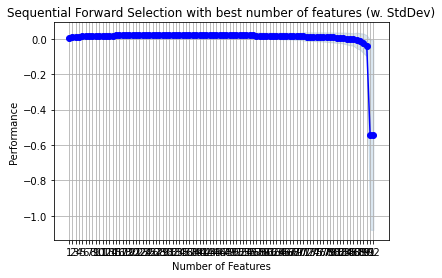

In [226]:
sfs = SFS(LinearRegression(),
           forward=True, 
          k_features='best',
           floating=False, 
           scoring='r2',
           cv=3)

sfs = sfs.fit(X_train, y_train)
print('best combination (r2: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_names_))
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection with best number of features (w. StdDev)')
plt.grid()
plt.show()
# sfs.subsets_

best combination (r2: 0.088): ('Male', 'Zombie', 'Orange Side', 'Pigtails', 'Top Hat', 'Wild Blonde', 'Smile', 'Hoodie', '3D Glasses', 'Knitted Cap')



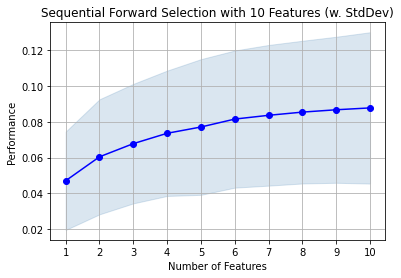

best combination (r2: 0.093): ('Male', 'Zombie', 'Orange Side', 'Buck Teeth', 'Pigtails', 'Pink With Hat', 'Top Hat', 'Cowboy Hat', 'Wild Blonde', 'Purple Hair', 'Smile', 'Hoodie', 'Blue Eye Shadow', '3D Glasses', 'Headband', 'Knitted Cap', 'Stringy Hair', 'Shadow Beard', 'Horned Rim Glasses', 'Black Lipstick')



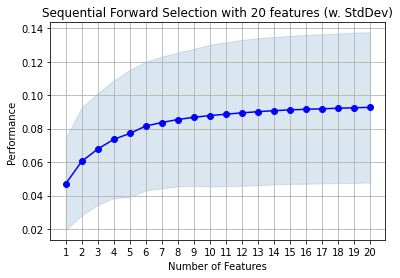

best combination (r2: 0.095): ('Male', 'Zombie', 'Orange Side', 'Buck Teeth', 'Pigtails', 'Pink With Hat', 'Top Hat', 'Cowboy Hat', 'Wild Blonde', 'Clown Hair Green', 'Straight Hair', 'Silver Chain', 'Purple Hair', 'Medical Mask', 'Police Cap', 'Clown Nose', 'Smile', 'Hoodie', 'Purple Eye Shadow', 'Blue Eye Shadow', '3D Glasses', 'Shaved Head', 'Headband', 'Knitted Cap', 'Mohawk', 'Stringy Hair', 'Shadow Beard', 'Horned Rim Glasses', 'Black Lipstick', 'Mole')



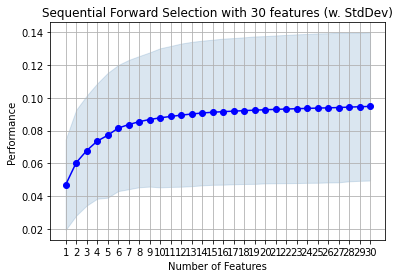

best combination (r2: 0.095): ('Male', 'Zombie', 'Orange Side', 'Buck Teeth', 'Pigtails', 'Pink With Hat', 'Top Hat', 'Cowboy Hat', 'Wild Blonde', 'Clown Hair Green', 'Straight Hair', 'Silver Chain', 'Purple Hair', 'Medical Mask', 'Police Cap', 'Clown Nose', 'Smile', 'Hoodie', 'Purple Eye Shadow', 'Blue Eye Shadow', '3D Glasses', 'Shaved Head', 'Headband', 'Knitted Cap', 'Mohawk', 'Stringy Hair', 'Shadow Beard', 'Horned Rim Glasses', 'Black Lipstick', 'Mole')



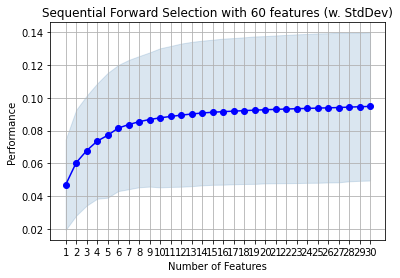

In [225]:
#10 features
sfs2 = SFS(LinearRegression(),
           forward=True, 
          k_features=10,
           floating=False, 
           scoring='r2',
           cv=3)

sfs2 = sfs2.fit(X_na_train, y_na_train)
print('best combination (r2: %.3f): %s\n' % (sfs2.k_score_, sfs2.k_feature_names_))

fig2 = plot_sfs(sfs2.get_metric_dict(), kind='std_err')


plt.title('Sequential Forward Selection with 10 Features (w. StdDev)')
plt.grid()
plt.show()

# 20 features
sfsback_20= SFS(LinearRegression(),
           forward=True, 
          k_features=20,
           floating=False, 
           scoring='r2',
           cv=3)

sfsbackfit_20 = sfsback_20.fit(X_na_train, y_na_train)
print('best combination (r2: %.3f): %s\n' % (sfsbackfit_20.k_score_, sfsbackfit_20.k_feature_names_))
fig_20 = plot_sfs(sfsbackfit_20.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection with 20 features (w. StdDev)')
plt.grid()
plt.show()

# 30 features
sfsback = SFS(LinearRegression(),
           forward=True, 
          k_features=30,
           floating=False, 
           scoring='r2',
           cv=3)

sfsbackfit = sfsback.fit(X_na_train, y_na_train)
print('best combination (r2: %.3f): %s\n' % (sfsbackfit.k_score_, sfsbackfit.k_feature_names_))

fig2 = plot_sfs(sfsbackfit.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection with 30 features (w. StdDev)')
plt.grid()
plt.show()

# 60 features
sfsback = SFS(LinearRegression(),
           forward=True, 
          k_features=60,
           floating=False, 
           scoring='r2',
           cv=3)

sfs = sfs.fit(X_na_train, y_na_train)
print('best combination (r2: %.3f): %s\n' % (sfsbackfit.k_score_, sfsbackfit.k_feature_names_))
fig2 = plot_sfs(sfsbackfit.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection with 60 features (w. StdDev)')
plt.grid()
plt.show()

best combination (r2: 0.093): ('Male', 'Zombie', 'Orange Side', 'Buck Teeth', 'Pigtails', 'Pink With Hat', 'Top Hat', 'Cowboy Hat', 'Wild Blonde', 'Purple Hair', 'Smile', 'Hoodie', 'Blue Eye Shadow', '3D Glasses', 'Headband', 'Knitted Cap', 'Stringy Hair', 'Shadow Beard', 'Horned Rim Glasses', 'Black Lipstick')



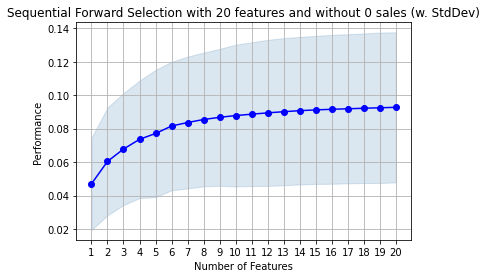

<Figure size 432x288 with 0 Axes>

In [222]:
# Picture Export
print('best combination (r2: %.3f): %s\n' % (sfsbackfit_20.k_score_, sfsbackfit_20.k_feature_names_))
fig_20 = plot_sfs(sfsbackfit_20.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection with 20 features (w. StdDev)')
plt.grid()
plt.show()
plt.savefig('foward_selection')

# LGBM Regessor Gradient Boosting
Trained an testes on data that only has non null sales

In [178]:
lgb_model = lgb.LGBMRegressor(
    boosting_type= 'gbdt', 
    num_leaves=5, 
    n_estimators=300,
    reg_lambda =1.0
)
lgb_model.fit(X_train, y_train)
lgb_y_pred = lgb_model.predict(X_test)

print('Result for LGB \n')
print('Test R^2: ', lgb_model.score(X_test, y_test))
print('Adjusted Rsquared Train: {}.'.format(1 - (1-lgb_model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)))
print('Adjusted Rsquared Test: {}.'.format(1 - (1-lgb_model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, lgb_y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, lgb_y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, lgb_y_pred)))

Result for LGB 

Test R^2:  -0.009457893714851062
Adjusted Rsquared Train: 0.2748290312751238.
Adjusted Rsquared Test: -0.04176332527558091.
Mean Absolute Error: 22288.1522470252
Mean Squared Error: 6101214466.238349
Root Mean Squared Error: 78110.27119552427


# Linear Regression w/o 0 and with outlier truncation

In [ ]:
sales = df_tr[df_tr['type'].str.contains("Sold")].reset_index(drop=True)
sales = sales.drop(['from', 'to', 'type', 'amount_in_eth'], axis=1)
sales = sales.groupby(['punk_id'])['amount_in_dol'].mean().reset_index()
sales.dropna(axis = 0, how='any', inplace=True)
sales.head()


In [ ]:
sales.boxplot()

In [ ]:
sales.amount_in_dol = outlier_truncation(sales.amount_in_dol)
sales.boxplot()

In [ ]:
## Join accessoires and prices
df_na = pd.merge(sales, types_dummies, on="punk_id", how='left')
df_na= pd.merge(df_na, acc, on="punk_id", how='left')

df_na = df_na.set_index(['punk_id'])
df_na.fillna(0, inplace=True)

In [ ]:
y = df_na['amount_in_dol']
y = y.round(decimals=-2)

X = df_na.iloc[:,1:]
X = X.astype(int)

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())